The aim of this notebook is to by optimising the position and dwell times of point sources along constrained lines produce a minimum exposure to one cube while producing a maximum exposure to a second cube.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from utilities import BasinhoppingWrapper

Create the voxels

In [2]:
x_ = np.linspace(-1, 1, 21)
y_ = np.linspace(-1, 1, 21)
z_ = np.linspace(-1, 1, 21)

x, y, z = np.meshgrid(x_, y_, z_)
x = np.ravel(x)
y = np.ravel(y)
z = np.ravel(z)

Define the target and avoid cubes

In [3]:
target_cube = (
    (x < 0.5) & (x > -0.5) & 
    (y < 0.5) & (y > -0.5) & 
    (z < 0.5) & (z > -0.5))

avoid_cube = (
    (x < 1) & (x > 0.5) & 
    (y < 0.25) & (y > -0.25) & 
    (z < 0.25) & (z > -0.25))

other = (~target_cube) & (~avoid_cube)

Define the target surface

In [4]:
target_distances = (
    (np.reshape(x[~target_cube], (-1, 1)) - 
     np.reshape(x[target_cube], (1, -1)))**2 +
    (np.reshape(y[~target_cube], (-1, 1)) - 
     np.reshape(y[target_cube], (1, -1)))**2 +
    (np.reshape(z[~target_cube], (-1, 1)) - 
     np.reshape(z[target_cube], (1, -1)))**2
)

shortest_dist_to_external = np.min(target_distances, axis=0)
target_surface = (
    shortest_dist_to_external < np.min(shortest_dist_to_external) 
    + 0.00001)

Display the target and avoid cubes

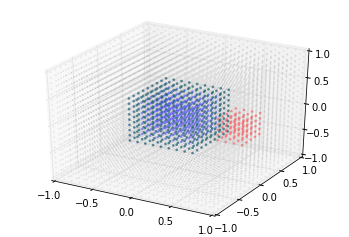

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[other], y[other], z[other], 
    alpha=0.1, s=1, color='grey')
ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.3, s=3, color='blue')
ax.scatter(
    x[target_cube][target_surface], 
    y[target_cube][target_surface], 
    z[target_cube][target_surface],
    alpha=0.3, s=3, color='green')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.3, s=3, color='red')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

plt.show()

Create initial equidistant parrallel lines with a random skew

In [6]:
number_of_lines = 16

line_start = np.meshgrid(
    [-0.3, -0.1, 0.1, 0.3],
    [-0.3, -0.1, 0.1, 0.3],
    [1])

line_finish = np.array([
    line_start[0] + np.random.normal(scale=0.05, size=[4,4,1]),
    line_start[1] + np.random.normal(scale=0.05, size=[4,4,1]),
    -line_start[2]])

In [7]:
line_start = np.array([np.ravel(mesh) for mesh in line_start])
line_finish = np.array([np.ravel(mesh) for mesh in line_finish])

Display the lines overlayed

(-1, 1)

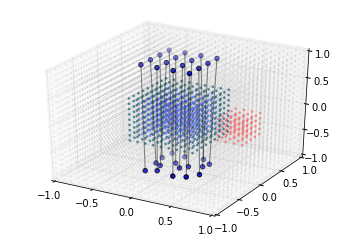

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[other], y[other], z[other], 
    alpha=0.1, s=1, color='grey')
ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.3, s=3, color='blue')
ax.scatter(
    x[target_cube][target_surface], 
    y[target_cube][target_surface], 
    z[target_cube][target_surface],
    alpha=0.3, s=3, color='green')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.3, s=3, color='red')
ax.scatter(*line_start)
ax.scatter(*line_finish)

for i in range(len(line_start[0])):
    plt_coords = [
        [line_start[j][i], line_finish[j][i]]
        for j in range(len(line_start))]
    ax.plot(*plt_coords, color='black', alpha=0.5)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create a function to return x, y, z coords when a distance along a line is requested

In [9]:
diff = (line_finish - line_start)
line_length = np.sqrt(diff[0]**2 + diff[1]**2 + diff[2]**2)

def find_distance_coords(line_num=None, distance=None):
    relative_dist = distance / line_length[line_num]
    
    if (relative_dist > 1) | (relative_dist < 0):
        return np.array([np.nan]*3)
    
    x = (
        line_start[0][line_num] * (1 - relative_dist) + 
        line_finish[0][line_num] * relative_dist)
    
    y = (
        line_start[1][line_num] * (1 - relative_dist) + 
        line_finish[1][line_num] * relative_dist)
        
    z = (
        line_start[2][line_num] * (1 - relative_dist) + 
        line_finish[2][line_num] * relative_dist)
    
    coords = np.array([x, y, z])
    
    return coords

Pick dwell positons 0.1 units apart starting at a random position along the line

In [10]:
dwell_spacing = 0.1
number_of_dwells = np.floor(2 / dwell_spacing).astype(int)

In [11]:
inital_dwell_position = np.random.uniform(
    low=0, high=dwell_spacing, size=number_of_lines)
inital_dwell_position

array([ 0.08567555,  0.04728275,  0.03795643,  0.00507546,  0.05816416,
        0.06626872,  0.08575274,  0.0811324 ,  0.07311814,  0.08417024,
        0.04125188,  0.03258711,  0.0133193 ,  0.09444123,  0.03198501,
        0.06881746])

In [12]:
def find_dwell_coords(line_num=None, dwell_num=None):
    distance = (inital_dwell_position[line_num] + 
                dwell_num * dwell_spacing)
    
    coords = find_distance_coords(
        line_num=line_num, distance=distance)
    
    return coords

In [13]:
dwell_positions = np.array([
    [
        find_dwell_coords(
            line_num=line_num, dwell_num=dwell_num)
        for dwell_num in range(number_of_dwells)]
 for line_num in range(number_of_lines)])

In [14]:
relevant_dwell_positions = np.reshape(dwell_positions, (-1, 3))
keep = ((relevant_dwell_positions[:,2] < 0.5) & 
        (relevant_dwell_positions[:,2] > -0.5))
relevant_dwell_positions = relevant_dwell_positions[keep]

Plot the dwell positions

(-1, 1)

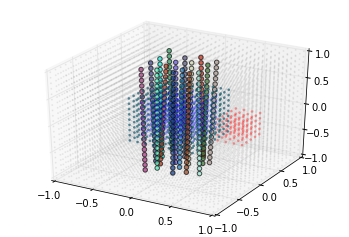

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[other], y[other], z[other], 
    alpha=0.1, s=1, color='grey')
ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.3, s=3, color='blue')
ax.scatter(
    x[target_cube][target_surface], 
    y[target_cube][target_surface], 
    z[target_cube][target_surface],
    alpha=0.3, s=3, color='green')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.3, s=3, color='red')

for line_num in range(number_of_lines):
    colour = np.random.uniform(size=3)
    ax.scatter(*np.transpose(dwell_positions[line_num]), 
               c=colour, alpha=0.7)


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create an array containing the distance to each dwell position for each voxel and translate this to exposure at that voxel per unit dwell time at each dwell position

In [16]:
distance_to_dwell_pos = np.array([
    np.sqrt(
        (x[i] - relevant_dwell_positions[:,0])**2 + 
        (y[i] - relevant_dwell_positions[:,1])**2 + 
        (z[i] - relevant_dwell_positions[:,2])**2
    )
    for i in range(len(x))
])

exposure_per_unit_time = 1 / distance_to_dwell_pos**2

Run a test of arbitrary dwell times

In [17]:
num_relevant_dwells = len(relevant_dwell_positions)

random_pick = np.random.uniform(
    size=2, high=num_relevant_dwells, low=0).astype(int)

dwell_times = np.zeros([1, num_relevant_dwells])
dwell_times[0, random_pick] = 10

In [18]:
def calculate_exposure(dwell_times):
    exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)
    return exposure

In [19]:
exposure = calculate_exposure(dwell_times)

(-1, 1)

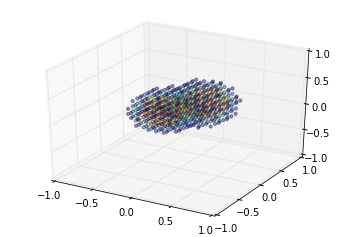

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

reference = exposure > 80
colour = exposure[reference]
colour[colour > 200] = 200

ax.scatter(
    x[reference], y[reference], z[reference], 
    alpha=0.4, s=10, c=colour, cmap=cm.jet)


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

In [21]:
def display_results(dwell_times):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    reference = exposure > 25
    colour = exposure[reference]
    colour[colour > 100] = 100
    
    small = exposure[reference] < 50
    large = ~small

    ax.scatter(
        x[reference][small], y[reference][small], z[reference][small], 
        alpha=0.2, s=3, c=colour[small], cmap=cm.jet)
    
    ax.scatter(
        x[reference][large], y[reference][large], z[reference][large], 
        alpha=0.4, s=20, c=colour[large], cmap=cm.jet)


    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    cost_function(dwell_times, debug=True)
    
    plt.show()

Create cost function

(0, 100)

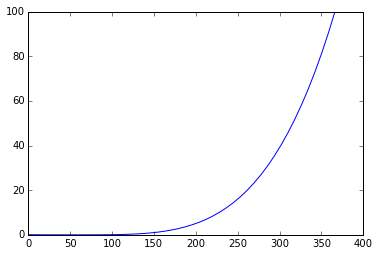

In [22]:
def hot_surface_cost_function(max_target_surface):
    return ((max_target_surface-50)/100)**4

testx = np.linspace(0, 400)
testy = hot_surface_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 100])

(0, 100)

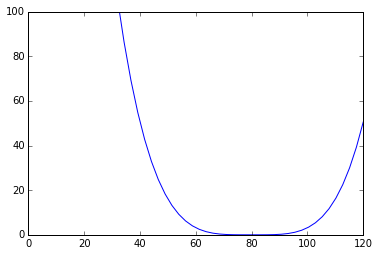

In [23]:
def cold_target_cost_function(min_target):
    return ((min_target-80)/15)**4

# Example coverage cost function
testx = np.linspace(0, 120)
testy = cold_target_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 100])

In [24]:
min_target_goal = 50
max_avoid_goal = 10
max_target_surface_goal = 100

def cost_function(dwell_times, debug=False):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    min_target = np.min(exposure[target_cube])
    max_target_surface = np.max(exposure[target_cube][target_surface])
    
    cold_target_cost = cold_target_cost_function(min_target)
    hot_surface_cost = hot_surface_cost_function(max_target_surface)
    
    if debug:
        print(max_target_surface)
        print(hot_surface_cost)
        print()
        print(min_target)
        print(cold_target_cost)
    
    return hot_surface_cost + cold_target_cost

Create initial conditions

In [37]:
num_relevant_dwells

160

In [33]:
initial_conditions = np.ones(num_relevant_dwells)*0.01

Step noise

In [34]:
step_noise = np.ones(num_relevant_dwells) * 0.1

Bounds

In [35]:
bounds = ((0, None),)*num_relevant_dwells

Run the optimiser

258.426016193
18.8715560114

56.8904800817
5.63376409454


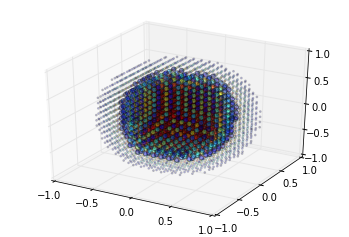

311.223592352
46.5639259965

45.8154695577
26.974502219


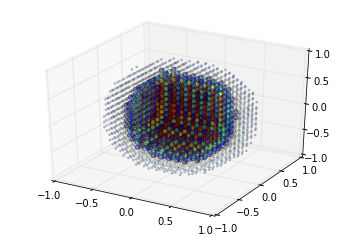

246.076146203
14.7808377512

56.1549611787
6.38597331024


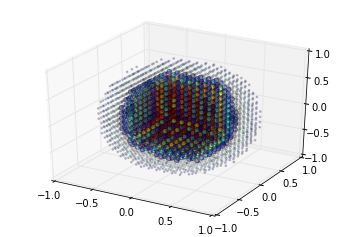

345.637815343
76.3906028504

58.2346666079
4.43298497483


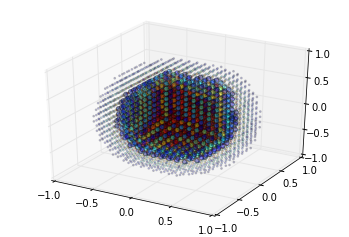

235.32476849
11.7959755874

56.4564342735
6.06909474404


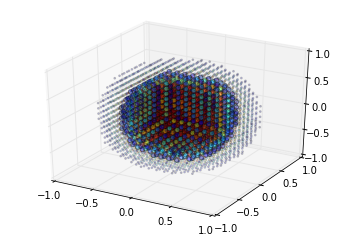

260.106913588
19.487735325

58.696713607
4.06837884472


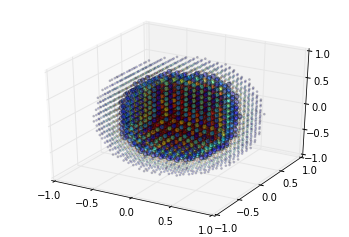

1130.99397787
13655.04382

45.4048996167
28.2939345284


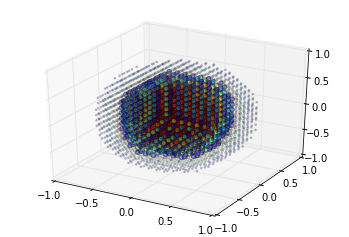

237.169767837
12.2727759713

56.8723096831
5.65150371632


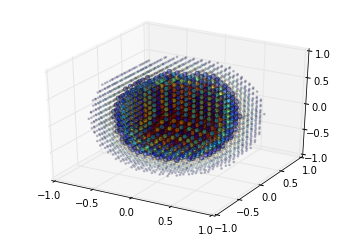

229.966312218
10.4897435201

57.5674272265
5.00208773745


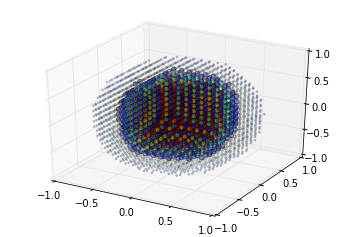

212.720518557
7.0108274489

60.0732660788
3.11443628737


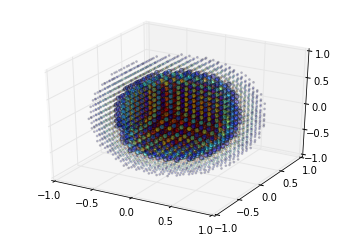

264.510906434
21.1737368894

76.948680756
0.00171232247079


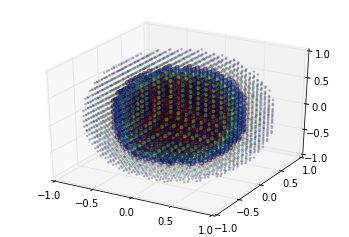

199.071755491
4.93834541102

59.9076850882
3.21925122152


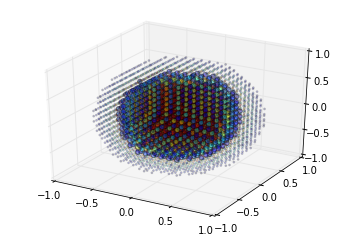

In [40]:
optimisation = BasinhoppingWrapper(
    to_minimise=cost_function,
    initial=initial_conditions,
    step_noise=step_noise,
    basinhopping_confidence=2,
    optimiser_confidence=0.0001,
    n=2,
    debug=display_results,
    bounds=bounds
)

199.071755491
4.93834541102

59.9076850882
3.21925122152


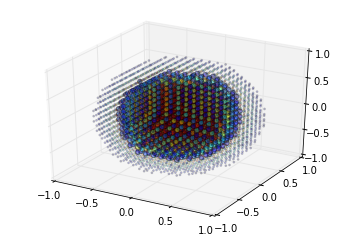

In [41]:
display_results(optimisation.result)

(array([ 45.,  38.,  24.,  16.,  17.,   7.,   7.,   4.,   0.,   2.]),
 array([ 0.00073111,  0.05611095,  0.11149079,  0.16687063,  0.22225046,
         0.2776303 ,  0.33301014,  0.38838998,  0.44376982,  0.49914966,
         0.5545295 ]),
 <a list of 10 Patch objects>)

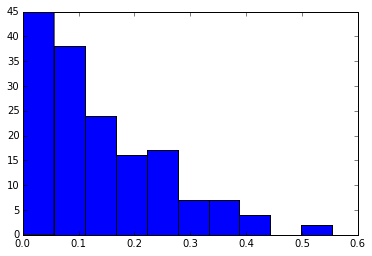

In [42]:
plt.hist(optimisation.result)

In [56]:
dwell_times = np.reshape(optimisation.result, (1, num_relevant_dwells))
exposure = calculate_exposure(dwell_times)

exposure = np.reshape(exposure, (21, 21, 21))
plot_exposure = exposure.copy()
plot_exposure[exposure > 250] = 250

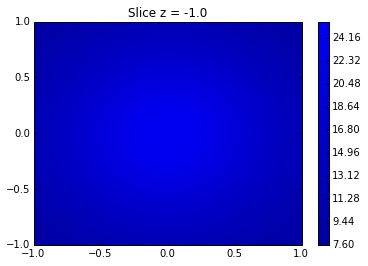

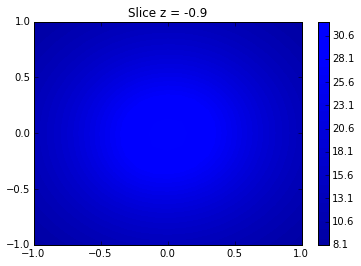

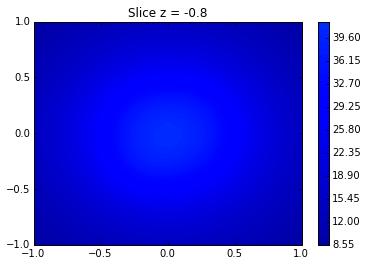

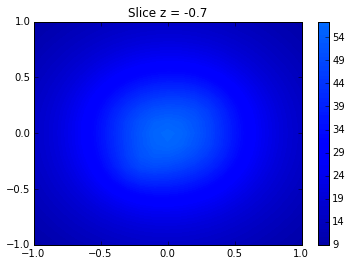

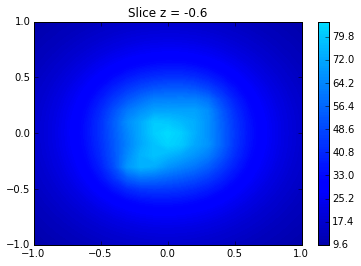

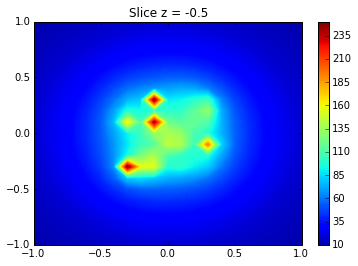

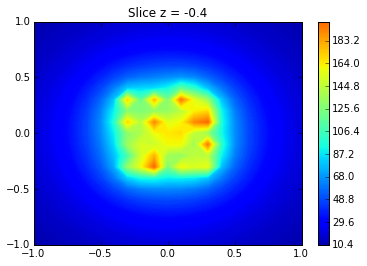

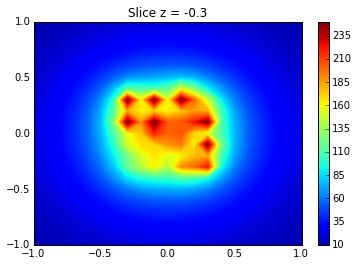

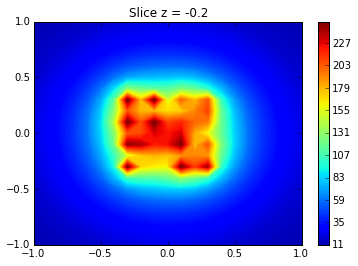

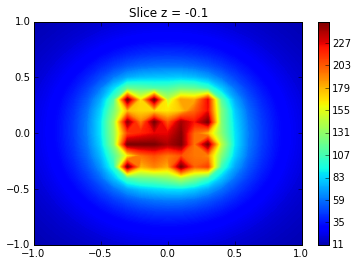

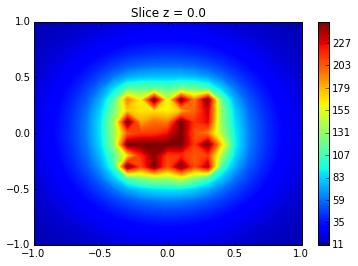

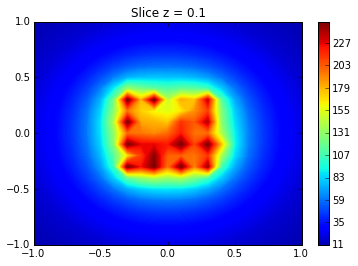

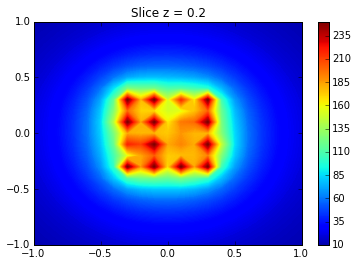

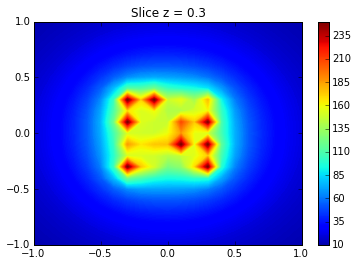

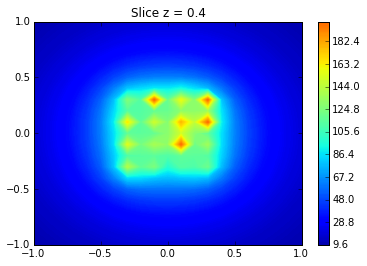

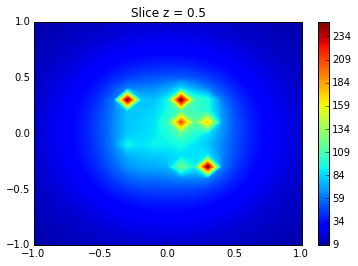

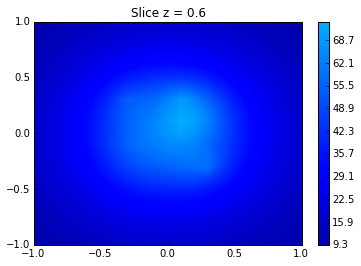

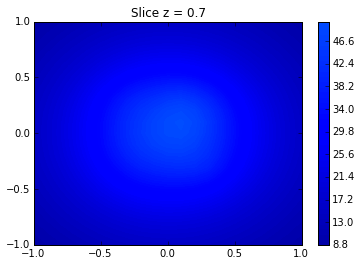

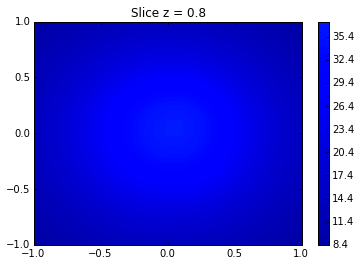

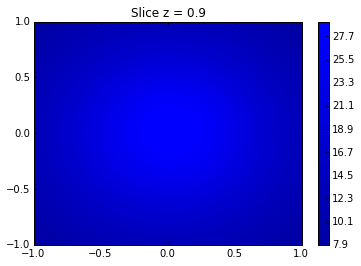

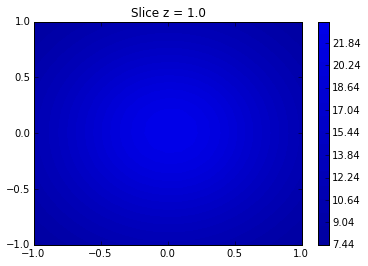

In [62]:
for i in range(21):
    c = plt.contourf(x_, y_,
        plot_exposure[:, :, i], 250,
        vmin=0, vmax=250
    )
    
    plt.title("Slice z = %s" % (str(z_[i])))
    plt.colorbar(c)
    plt.show()